In [1]:
import pandas as pd
import numpy as np
from IPython.display import Markdown
import subprocess as sp

## Cómputo de la poligonal auxiliar

In [2]:
BASE = 'IGM1'
POLIGONAL = './poligonal.csv'
COORDENADAS = './Resultados.csv'

In [3]:
verticesdf = pd.read_csv(POLIGONAL,index_col=0)

In [4]:
vertices = [*verticesdf.index]

In [5]:
from numbers import Number
from typing import Tuple
from math import floor

def dms2deg(dms:Tuple[int,int,float]) -> float:
    d: int
    m: int
    s: float

    d,m,s = dms    

    return d + m/60. + s/3600.

def deg2dms(deg:Number) -> Tuple[int,int,float]:
    d: int
    m: int
    s: float

    side: int = -1 if deg < 0 else 1
    deg = abs(deg)
    d = floor(deg)
    _m = deg - d
    _m *= 60
    m = floor(_m)
    _s = _m - m
    _s *= 60
    s = _s

    return d*side, m, s

def check_angulos(listado):
    d,m,s = (sum(map(round,i)) for i in zip(*listado))
    return d+(m+s/60)/60

def azimsum(d1,m1,s1,d2,m2,s2):
    dd_ = d1+d2
    mm_ = m1+m2
    ss_ = s1+s2
    ss = ss_ % 60
    mm_ += ss_ // 60
    mm = mm_ % 60
    dd_ += mm_ // 60
    dd = dda if (dda := dd_ + 180) < 360 else dd_ - 180
    
    return dd,mm,ss

def azTotuple(st):
    return tuple([int(i) for i in st.replace('°',' ').replace('\"',' ').replace('\'',' ').split()])

def tupleToAz(tupla):
    return '{}°{}\'{:.0f}\"'.format(*tupla)

def tupleToLat(tupla):
    return '{}°{}\'{:.5f}\" {}'.format(*tupla,'S' if tupla[0] < 0 else 'N').strip('-')

def tupleToLon(tupla):
    return '{}°{}\'{:.5f}\" {}'.format(*tupla,'O' if tupla[0] < 0 else 'E').strip('-')

In [6]:
COORDRENAMES={'latitud':'Latitud','longitud':'Longitud',
                               'lat':'Latitud','lon':'Longitud','long':'Longitud',
                               'Lat':'Latitud','Lon':'Longitud','Long':'Longitud',
                               'latitude':'Latitud','longitude':'Longitud',
                               'az':'Azimut','azimut':'Azimut'
                              }
def get_dist(salida,llegada,pl):
    if (mask := (pl.Llegada == llegada) & (pl.Partida == salida)).any():
        return pl.loc[mask,'Distancia'].values[0]
    else:
        mask = (pl.Llegada == salida) & (pl.Partida == llegada)
        return pl.loc[mask,'Distancia'].values[0]

def get_az(salida,llegada,pl):
    if (mask := (pl.Llegada == llegada) & (pl.Partida == salida)).any():
        return dms2deg(azTotuple(pl.loc[mask,'Azimut'].values[0]))
    else:
        mask = (pl.Llegada == salida) & (pl.Partida == llegada)
        az = pl.loc[mask,'Azimut'].values[0] 
        return dms2deg(azimsum(*azTotuple(az),0,0,0))
    
def tabla_geod(vectorGNSS,vertices,planilla):
    vector1 = {'Partida':vertices[0],
               'Llegada':vertices[1],
              }
    partida1 = {**vectorGNSS.loc[['latitud','longitud'],vector1['Partida']]
               }
    datos1 = {
        'Azimut': get_az(vector1['Partida'],vector1['Llegada'],planilla),
        'Distancia': get_dist(vector1['Partida'],vector1['Llegada'],planilla)
    }
    vector2 = {'Partida':vertices[-1],
               'Llegada':vertices[-2],
              }
    partida2 = {**vectorGNSS.loc[['latitud','longitud'],vector2['Partida']]
               }
    datos2 = {
        'Azimut': get_az(vector2['Partida'],vector2['Llegada'],planilla),
        'Distancia': get_dist(vector2['Partida'],vector2['Llegada'],planilla)
    }
    df = pd.DataFrame([{**vector1,**partida1,**datos1},{**vector2,**partida2,**datos2}])
    df = df.rename(columns={i:i[0].upper()+i[1:] for i in df.columns}).T\
           .reindex('Partida,Latitud,Longitud,Azimut,Distancia,Llegada'.split(',')).T
    return df 

def formatcoords(df):
    df = df.rename(columns=COORDRENAMES)
    try: df.Latitud = df.Latitud.apply(lambda x: tupleToLat(deg2dms(x)))
    except AttributeError: pass
    try: df.Longitud = df.Longitud.apply(lambda x: tupleToLon(deg2dms(x)))
    except AttributeError: pass
    try: df.Azimut = df.Azimut.apply(lambda x: tupleToAz(deg2dms(x)))
    except AttributeError: pass
    
    return df

In [58]:
(rollvert := vertices.copy()).append(rollvert.pop(0)) #Version rotada de los vertices
(rollvertr := vertices.copy()).insert(0,rollvertr.pop()) #Version rotada al reves

lados = np.roll(verticesdf.values,-1,axis=0) - verticesdf.values
ladosdf = pd.DataFrame((lados**2).sum(axis=-1)**0.5,index=[*zip(vertices,rollvert) ],columns=['distancia'])

Markdown(ladosdf.to_markdown(floatfmt='.3f'))

ladosdfsim = pd.DataFrame({**{ix[::-1]:v for ix,v in ladosdf.iterrows()},**{ix:v for ix,v in ladosdf.iterrows()}}).T

#Markdown(ladosdfsim.to_markdown(floatfmt='.3f'))

In [59]:
orientaciones = np.arctan2(*lados.T)
orientaciones0a2pi = np.array([i if (j:= i + 2*np.pi) > 2*np.pi else j for i in orientaciones])

angulos = (np.pi - np.roll(orientaciones0a2pi,1)) + orientaciones0a2pi
angulosDMS = [(i if i < 360 else i-360, j, k) for i,j,k in [deg2dms(np.degrees(i)) for i in angulos]]

check_angulos(angulosDMS)

angulosdf = pd.DataFrame(angulosDMS,index=[*zip(rollvertr,vertices,rollvert)],columns=['d','m','s.ss'])

angulosdfsim = pd.DataFrame({**{ix[::-1]:v for ix,v in angulosdf.iterrows()},**{ix:v for ix,v in angulosdf.iterrows()}}).T

#Markdown(angulosdfsim.to_markdown(floatfmt='.0f'))

In [9]:
vectorGNSS = pd.read_csv(COORDENADAS,index_col=0)

In [11]:
mdIntro = """
# Medición auxiliar

Debido a que los vertices de la mensura no presentan condiciones favorables para la medición GPS
se procedió a vincular un vector auxiliar ({v1}-{v2}), que se vinculó a los vertices de mensura
mediante la medición de una poligonal con instrumental topográfico.

A partír de la resolución del problema geodésico inverso se calcularon los parámetros 
de los vectores medidos con GNSS

{tabla1}

{tabla2}

La poligonal medida se inicia sobre el lado {v2}-{v1}

"""

In [12]:
#+BEGIN_SRC bash :results table :exports none

inp="{latitud} {longitud} ".format(**vectorGNSS[BASE])+"{latitud} {longitud}".format(**vectorGNSS[vertices[0]])

pInvLargo = sp.check_output(['geod', '-I', '-p', '+ellps=GRS80'],input=inp.encode())\
                            .decode().replace('d','°').split()
pInvLdf = pd.DataFrame([pInvLargo],
                          columns=['Azimut Directo','Azimut Inverso','Distancia'],
                          index = [f'{BASE}-{vertices[0]}'])

coords="{latitud} {longitud} ".format(**vectorGNSS[vertices[0]])+"{latitud} {longitud}".format(**vectorGNSS[vertices[-1]])
pInvCorto = sp.check_output(['geod', '-I', '-p', '+ellps=GRS80'],input=coords.encode())\
                            .decode().replace('d','°').split()
pInvCdf = pd.DataFrame([pInvCorto],
                          columns=['Azimut Directo','Azimut Inverso','Distancia'],
                          index = [f'{vertices[0]}-{vertices[-1]}'])


In [13]:

parms = {
    'v1': vertices[0],
    'v2': vertices[-1],
    'tabla1': pInvLdf.to_markdown(floatfmt='.3f'),
    'tabla2': pInvCdf.to_markdown(floatfmt='.3f')
}
Markdown(mdIntro.format(**parms))


# Medición auxiliar

Debido a que los vertices de la mensura no presentan condiciones favorables para la medición GPS
se procedió a vincular un vector auxiliar (PFD1-PFD2), que se vinculó a los vertices de mensura
mediante la medición de una poligonal con instrumental topográfico.

A partír de la resolución del problema geodésico inverso se calcularon los parámetros 
de los vectores medidos con GNSS

|           | Azimut Directo   | Azimut Inverso   |   Distancia |
|:----------|:-----------------|:-----------------|------------:|
| IGM1-PFD1 | 217°13'31.19"    | 37°25'35.522"    |   53278.694 |

|           | Azimut Directo   | Azimut Inverso   |   Distancia |
|:----------|:-----------------|:-----------------|------------:|
| PFD1-PFD2 | 42°45'17.412"    | 222°44'58.411"   |    1239.804 |

La poligonal medida se inicia sobre el lado PFD2-PFD1



In [16]:
azts = [tuple(i.replace('°',' ').replace('\"',' ').replace('\'',' ').split()) for i in pInvCorto[:2]]
etq = [('PFD1','PFD2'),('PFD2','PFD1')]
azimutdict = {i:(int(j[0]),int(j[1]),float(j[2])) for i,j in zip(etq,azts)}

In [17]:
previo = None
este = vertices[-1]
planilla=[]

for proximo in [*vertices,vertices[0]]:
    #print(previo,este,proximo)
    if previo is None:
        angulo = None
        az = azimutdict[(este,proximo)]
    else:
        angulo = angulosdfsim.xs((previo,este,proximo))
        az = azimsum(*azimutdict[(previo,este)],*angulo)
        azimutdict[(este,proximo)] = az

    planilla.append([este,('{:.0f}°{:.0f}\'{:.0f}\"'.format(*angulo) if not angulo is None else ''),'{:.0f}°{:.0f}\'{:.0f}\"'.format(*az),ladosdfsim.loc[(este,proximo)].iloc[0],proximo])

    previo = este
    este = proximo
    
poligonal= pd.DataFrame(planilla,columns='Partida Angulo Azimut Distancia Llegada'.split())

problemasGeod=tabla_geod(vectorGNSS,vertices,poligonal)

In [18]:
mdPoligonal ="""

La poligonal medida y compensada está expresada en la tabla que sigue. A partir
de estos valores, se calcularon las coordenadas de los puntos {v1} y {v2} resolviendo
el problema geodésico directo.

{tabla_1}

El planteo del Problema geodésico queda expresado como sigue.

{tabla_2}
"""

In [19]:
parms = {
    'v1':vertices[1],
    'v2':vertices[0],
    'tabla_1': poligonal.to_markdown(floatfmt='.3f',index=False),
    'tabla_2': formatcoords(problemasGeod).to_markdown(floatfmt='.3f',index=False)
}

Markdown(mdPoligonal.format(**parms))



La poligonal medida y compensada está expresada en la tabla que sigue. A partir
de estos valores, se calcularon las coordenadas de los puntos I y PFD1 resolviendo
el problema geodésico directo.

| Partida   | Angulo     | Azimut     |   Distancia | Llegada   |
|:----------|:-----------|:-----------|------------:|:----------|
| PFD2      |            | 222°44'58" |    1239.805 | PFD1      |
| PFD1      | 124°50'56" | 167°35'54" |      11.366 | I         |
| I         | 54°43'17"  | 42°19'11"  |    1146.287 | H         |
| H         | 180°0'45"  | 42°19'56"  |     100.047 | PFD2      |
| PFD2      | 0°25'2"    | 222°44'58" |    1239.805 | PFD1      |

El planteo del Problema geodésico queda expresado como sigue.

| Partida   | Latitud           | Longitud          | Azimut     |   Distancia | Llegada   |
|:----------|:------------------|:------------------|:-----------|------------:|:----------|
| PFD1      | 34°57'14.94247" S | 58°47'31.88255" O | 167°35'54" |      11.366 | I         |
| PFD2      | 34°56'45.40044" S | 58°46'58.71314" O | 222°19'56" |     100.047 | H         |


In [20]:
inp = """% {Llegada}
{Latitud} {Longitud} {Azimut} {Distancia}
""".format(**problemasGeod.iloc[0])+"""% {Llegada}
{Latitud} {Longitud} {Azimut} {Distancia}
""".format(**problemasGeod.iloc[1])
          
pDir = sp.check_output(['geod', '-t%', '-p','-f','%.10f', '+ellps=GRS80'],input=inp.encode())\
                            .decode().replace('d','°').replace('%','').strip().split('\n')
it1 = iter([*map(lambda x: x.split(),pDir)])
pDirDF = pd.DataFrame([[*i,*j] for i,j in zip(it1,it1)],
                          columns=['Punto','Latitud','Longitud','Azimut']).\
                          set_index(['Punto']).drop(columns=["Azimut"])

#Encabezado
#!echo Latitud,Longitud,Azimut-Regreso
#Problema geodesico inverso
#!geod -t% -p -w5 +ellps=GRS80 << EOF | tr '\t' ',' {inp}


In [21]:
mdDirecto = """
El resultado del calculo del problema directo nos da las coordenadas 
geográficas de los vértices A y D de la mensura, las cuales se proyectarán
luego al sistema Gauss-Krügger en faja 5.

{tabla}
"""


In [22]:
Markdown(mdDirecto.format(tabla=pDirDF.to_markdown()))


El resultado del calculo del problema directo nos da las coordenadas 
geográficas de los vértices A y D de la mensura, las cuales se proyectarán
luego al sistema Gauss-Krügger en faja 5.

| Punto   |   Latitud |   Longitud |
|:--------|----------:|-----------:|
| I       |  -34.9543 |   -58.7922 |
| H       |  -34.9466 |   -58.7837 |


In [23]:
puntosDF = pd.concat([vectorGNSS.T.rename(columns=COORDRENAMES),pDirDF.astype(float)])

In [24]:
proj_form = "+proj=longlat +ellps=GRS80"
proj_to = "+proj=tmerc +lat_0=-90 +lon_0=-60 +x_0=5500000 "\
          + "+y_0=0 +ellps=GRS80"

inp = '\n'.join(puntosDF.T.apply(lambda x: '{Latitud} {Longitud}'.format(**x)))

coordTM = sp.check_output(['cs2cs', '-r' ,'-t%', '-f','%.3f', 
                       *proj_form.split(),'+to',
                       *proj_to.split(),
                       ],input=inp.encode())\
                            .decode().replace('d','°').replace('%','').strip().split('\n')

coordTMDF = pd.DataFrame([i.split() for i in coordTM],
                      columns=['Este','Norte','Altura'],
                      index=puntosDF.index)\
                          .drop(columns=["Altura"]).astype(float)


#Encabezado
#!echo Este,Norte,Z
#Problema geodesico inverso
#!cs2cs -r -t% -f "%.3f" {proj_from} +to {proj_to} << EOF | tr '\t ' ',' {inp}

In [50]:
mdCierre = """
# Resumen de coordenadas y Croquis.

Las coordenadas POSGAR07 quedan expresadas entonces segun la tabla a continuación
tanto en latitud y longitud como en sistema plano Gauss Krugger.

{tabla}
"""

In [51]:
param = {
    'tabla':formatcoords(puntosDF.join(coordTMDF)).to_markdown(floatfmt='.3f').replace('nan','')
}

Markdown(mdCierre.format(**param))


# Resumen de coordenadas y Croquis.

Las coordenadas POSGAR07 quedan expresadas entonces segun la tabla a continuación
tanto en latitud y longitud como en sistema plano Gauss Krugger.

|      | Latitud           | Longitud          |   altura |        Este |       Norte |
|:-----|:------------------|:------------------|---------:|------------:|------------:|
| IGM1 | 34°34'20.07733" S | 58°26'21.54958" O |   50.694 | 5643215.484 | 6173719.707 |
| PFD1 | 34°57'14.94247" S | 58°47'31.88255" O |   36.222 | 5610323.099 | 6131793.095 |
| PFD2 | 34°56'45.40044" S | 58°46'58.71314" O |   40.217 | 5611175.818 | 6132693.346 |
| I    | 34°57'15.30270" S | 58°47'31.78634" O |       | 5610325.406 | 6131781.964 |
| H    | 34°56'47.80045" S | 58°47'1.36837" O  |       | 5611107.538 | 6132620.199 |


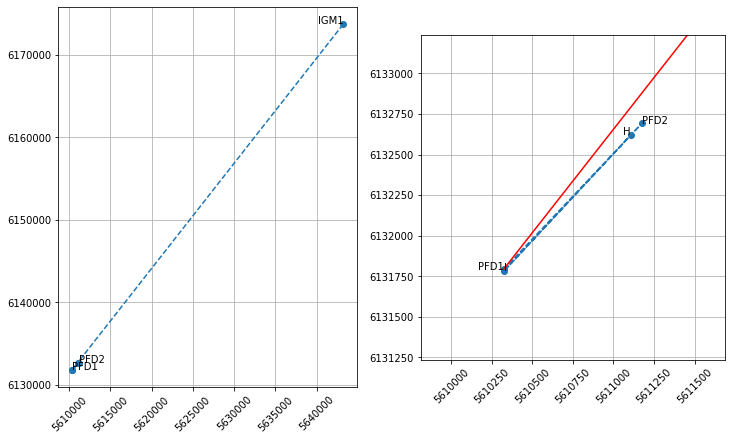

In [57]:
import matplotlib.pyplot as plt

fig,((ax1,ax2))=plt.subplots(1,2,figsize=(12,7))

ax1.ticklabel_format(useOffset=False, style='plain')
ax2.ticklabel_format(useOffset=False, style='plain')

ax1.plot(coordTMDF.Este,coordTMDF.Norte,'o--')
ax1.set_aspect('equal')
ax2.plot(coordTMDF.Este[1:],coordTMDF.Norte[1:],'o--')
ax2.set_aspect('equal')

xlim = ax2.get_xlim()

xrange = xlim[1]-xlim[0]
xmean = (xlim[1]+xlim[0])/2

ylim = ax2.get_ylim()

yrange = ylim[1]-ylim[0]
ymean = (ylim[1]+ylim[0])/2

ax2.plot(coordTMDF.Este[:2],coordTMDF.Norte[:2],'-r')

als = ['right','left','left','right']

for x,y,s,al in zip(coordTMDF.Este[1:],coordTMDF.Norte[1:],coordTMDF.index[1:],als):
    ax2.text(x,y,s,horizontalalignment=al)

for x,y,s,al in zip(coordTMDF.Este[:3],coordTMDF.Norte[:3],coordTMDF.index[:3],als[:3]):
    ax1.text(x,y,s,horizontalalignment=al)
    
ax2.set_xlim(xmean-xrange,xmean+xrange)
ax2.set_ylim(ymean-yrange,ymean+yrange)

new_l = [*map(lambda x: x.set_rotation(45),ax1.get_xticklabels())]
new_l = [*map(lambda x: x.set_rotation(45),ax2.get_xticklabels())]

ax1.grid('both')
ax2.grid('both')

fig.show()